# Part 0 - Preliminaries

## Install Libraries

In [1]:
#%pip install category_encoders

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,  MinMaxScaler
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import sys
import os
import warnings

warnings.filterwarnings("ignore")

# Apply Seaborn's aesthetic parameters to match Matplotlib's style
sns.set()

pd.set_option('display.max_columns', None)

FILE_NAME = "2016_Building_Energy_Benchmarking_Clean.csv.bz2"
TARGET_COLUMN = 'SiteEnergyUse(kBtu)'
DROP_COLUMN = 'TotalGHGEmissions'
STAR_COLUMN = 'ENERGYSTARScore'

# Load Data

In [3]:
df = pd.read_csv(FILE_NAME)
print(f"Rows - {df.shape[0]}\nColumns - {df.shape[1]}")
df.head()

Rows - 2532
Columns - 27


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFAParking,ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ComplianceStatus,Outlier,TotalGHGEmissions,No.PropertyTypes,AgeOfBuilding
0,4,3,7,6,1.0,12,0,157,13,88434.0,23,0.0,17,0.0,0,60.0,84.300003,189.000000,7226362.5,2003882.00,3946027.0,1276453.0,0,2,249.98,1.0,96
1,4,3,7,6,1.0,11,15064,163,13,83880.0,35,15064.0,36,4622.0,0,61.0,97.900002,179.399994,8387933.0,0.00,3242851.0,5145082.0,0,2,295.86,3.0,27
2,4,3,7,6,1.0,41,196718,157,13,756493.0,23,0.0,17,0.0,0,43.0,97.699997,244.100006,72587024.0,21566554.00,49526664.0,1493800.0,0,2,2089.28,1.0,54
3,4,3,7,6,1.0,10,0,157,13,61320.0,23,0.0,17,0.0,0,56.0,113.300003,224.000000,6794584.0,2214446.25,2768924.0,1811213.0,0,2,286.43,1.0,97
4,4,3,7,6,1.0,18,62000,168,13,123445.0,35,68009.0,42,0.0,0,75.0,118.699997,215.600006,14172606.0,0.00,5368607.0,8803998.0,0,2,505.01,3.0,43


# Recursive Feature Selection

Apply standard linear or non-linear models to determine the best features and models to act as a base line.

In [4]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 
    
def get_models(model_types):
    """Return a list of models based on the model type."""
    if model_types == "linear":
        return [LinearRegression(), LinearSVR(dual="auto"), Ridge(), Lasso(), ElasticNet()]
    elif model_types == "non-linear":
        return [DecisionTreeRegressor(), RandomForestRegressor(random_state=42),
                GradientBoostingRegressor(random_state=42), ExtraTreeRegressor(random_state=42)]
    else:
        raise ValueError("Invalid model_types value. Choose 'linear' or 'non-linear'.")

def feature_selection_and_evaluation(X_train, y_train, X_test, y_test, model):
    """Apply RFECV for feature selection and evaluate the model."""
    selector = RFECV(estimator=model, step=1, cv=5, scoring='r2', n_jobs=-1)
    selector.fit(X_train, y_train)
    
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
    
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    r2 = r2_score(y_test, y_pred)
    
    return r2, selector.support_

def best_features_via_rfecv(df, target_col, model_types):
    """
    Function to find the best features using RFECV and return the best model
    based on R2 score.
    """
    # Splitting the dataframe into features and target
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # Splitting into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    models = get_models(model_types)
    
    best_r2 = -np.inf  # Initialize with negative infinity as we aim to maximize R2
    best_features = None
    best_model = None
    
    for model in models:
        r2, feature_mask = feature_selection_and_evaluation(X_train, y_train, X_test, y_test, model)
        
        if r2 > best_r2:
            best_r2 = r2
            best_features = X.columns[feature_mask].tolist()
            best_model = model

    return best_features, best_model, best_r2


# DataFrames


In [5]:
#df1 = df.drop(columns=['SiteEnergyUse(kBtu)', 'ENERGYSTARScore']).dropna().copy()
#df2 = df.drop(columns=['SiteEnergyUse(kBtu)']).dropna().copy()

# Without Energy Star Score
df1 = df.drop(columns=[DROP_COLUMN, STAR_COLUMN]).dropna().copy()
# With Energy Star Score
df2 = df.drop(columns=[DROP_COLUMN]).dropna().copy()

# Apply RFECV

In [6]:
# Linear Models
best_cols_linear_v1, best_linear_model_v1, best_linear_r2_v1  = best_features_via_rfecv(df1, TARGET_COLUMN, "linear")
print(f"Best Model: {best_linear_model_v1}, Best R2 Score: {best_linear_r2_v1}, Best Features: {best_cols_linear_v1}")
best_cols_linear_v2, best_linear_model_v2, best_linear_r2_v2 = best_features_via_rfecv(df2, TARGET_COLUMN, "linear")
print(f"Best Model: {best_linear_model_v2}, Best R2 Score: {best_linear_r2_v2}, Best Features: {best_cols_linear_v2}")

# Non-Linear Models
best_cols_nonlinear_v1, best_nonlinear_model_v1, best_nonlinear_r2_v1 = best_features_via_rfecv(df1, TARGET_COLUMN, "non-linear")
print(f"Best Model: {best_nonlinear_model_v1}, Best R2 Score: {best_nonlinear_r2_v1}, Best Features: {best_cols_nonlinear_v1}")
best_cols_nonlinear_v2, best_nonlinear_model_v2, best_nonlinear_r2_v2 = best_features_via_rfecv(df2, TARGET_COLUMN, "non-linear")
print(f"Best Model: {best_nonlinear_model_v2}, Best R2 Score: {best_nonlinear_r2_v2}, Best Features: {best_cols_nonlinear_v2}")

Best Model: LinearRegression(), Best R2 Score: 0.9965097890263497, Best Features: ['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'ComplianceStatus', 'Outlier', 'No.PropertyTypes', 'AgeOfBuilding']
Best Model: LinearRegression(), Best R2 Score: 0.9965103158760229, Best Features: ['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyU

# Selected Variables

In [7]:
print(f"Total Variables - {len(df.columns.tolist())}")
df_vars = pd.DataFrame([best_cols_linear_v1, best_cols_linear_v2, best_cols_nonlinear_v1, best_cols_nonlinear_v2]).T
df_vars.columns = ["Linear - Without Energy Star Score", "Linear - With Energy Star Score", "Non-Linear - Without Energy Star Score", "Non-Linear - With Energy Star Score"]
df_vars

Total Variables - 27


,Linear - Without Energy Star Score,Linear - With Energy Star Score,Non-Linear - Without Energy Star Score,Non-Linear - With Energy Star Score
0,BuildingType,BuildingType,BuildingType,BuildingType
1,PrimaryPropertyType,PrimaryPropertyType,PrimaryPropertyType,PrimaryPropertyType
2,CouncilDistrictCode,CouncilDistrictCode,CouncilDistrictCode,NumberofBuildings
3,Neighborhood,Neighborhood,Neighborhood,NumberofFloors
4,NumberofBuildings,NumberofBuildings,NumberofBuildings,ListOfAllPropertyUseTypes
5,NumberofFloors,NumberofFloors,NumberofFloors,LargestPropertyUseType
6,PropertyGFAParking,PropertyGFAParking,LargestPropertyUseType,LargestPropertyUseTypeGFA
7,ListOfAllPropertyUseTypes,ListOfAllPropertyUseTypes,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA
8,LargestPropertyUseType,LargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA
9,LargestPropertyUseTypeGFA,LargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ENERGYSTARScore


# Base Line performance

In [8]:
# List of models and feature sets
models_and_features = [
    (best_cols_linear_v1, best_linear_model_v1), 
    (best_cols_linear_v2, best_linear_model_v2), 
    (best_cols_nonlinear_v1, best_nonlinear_model_v1), 
    (best_cols_nonlinear_v2, best_nonlinear_model_v2)
]

# Initialize DummyRegressor
dummy_model = DummyRegressor(strategy="mean")

# Loop through feature sets for DummyRegressor
for best_cols in [best_cols_linear_v1, best_cols_linear_v2, best_cols_nonlinear_v1, best_cols_nonlinear_v2]:
    models_and_features.append((best_cols, dummy_model))

# Loop through models and feature sets
for best_cols, model in models_and_features:
    
    # Splitting the data
    X = df[best_cols]
    y = df[TARGET_COLUMN]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Fit the model
    model.fit(X_train, y_train)
    
    # Get the score
    score = model.score(X_test, y_test)
    
    # Print results
    print(f"Model: {type(model).__name__}")
    print(f"Hyperparameters: {model.get_params()}")
    print(f"Features Used: {best_cols}")
    print(f"Test Score (R2): {score:.4f}")
    print("=" * 40)

Model: LinearRegression
Hyperparameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
Features Used: ['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'ComplianceStatus', 'Outlier', 'No.PropertyTypes', 'AgeOfBuilding']
Test Score (R2): 0.9965
Model: LinearRegression
Hyperparameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
Features Used: ['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'ListOfAllPropert

# Grid Search

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def perform_grid_search(df, target_col, best_model, best_features):
    """
    Perform Grid Search on the best model using the best features.
    """
    # Select only the best features and target column from the DataFrame
    X = df[best_features]
    y = df[target_col]
    
    # Splitting into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define hyperparameter grid based on the model type
    param_grid = {}
    if isinstance(best_model, LinearRegression):
        param_grid = {'fit_intercept': [True, False]}
    elif isinstance(best_model, LinearSVR):
        param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1]}
    elif isinstance(best_model, Ridge):
        param_grid = {'alpha': [0.01, 0.1, 1, 10], 'fit_intercept': [True, False], 'normalize': [True, False]}
    elif isinstance(best_model, Lasso):
        param_grid = {'alpha': [0.01, 0.1, 1, 10]}
    elif isinstance(best_model, ElasticNet):
        param_grid = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]}
    elif isinstance(best_model, DecisionTreeRegressor):
        param_grid = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
    elif isinstance(best_model, RandomForestRegressor):
        param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
    elif isinstance(best_model, GradientBoostingRegressor):
        param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 8]}
    elif isinstance(best_model, ExtraTreeRegressor):
        param_grid = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
    else:
        raise ValueError(f"Grid search not implemented for {type(best_model)}")
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid,
                               scoring=make_scorer(r2_score), cv=5, n_jobs=-1)
    
    # Fit the model on the training data
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters and best model
    best_params = grid_search.best_params_
    best_grid_model = grid_search.best_estimator_
    
    # Evaluate the model on the test data
    y_pred = best_grid_model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    
    return best_params, best_grid_model, test_r2

In [10]:
"""
(best_params_linear_model_v1, 
best_grid_linear_model_v1, 
test_r2_linear_model_v1) = perform_grid_search(df = df, 
                                               target_col = TARGET_COLUMN, 
                                               best_model = best_linear_model_v1, 
                                               best_features = best_cols_linear_v1)

(best_params_linear_model_v2, 
best_grid_linear_model_v2, 
test_r2_linear_model_v2) = perform_grid_search(df = df, 
                                               target_col = TARGET_COLUMN, 
                                               best_model = best_linear_model_v2, 
                                               best_features = best_cols_linear_v2)

(best_params_nonlinear_model_v1, 
best_grid_nonlinear_model_v1, 
test_r2_nonlinear_model_v1) = perform_grid_search(df = df, 
                                               target_col = TARGET_COLUMN, 
                                               best_model = best_nonlinear_model_v1, 
                                               best_features = best_cols_nonlinear_v1)

(best_params_nonlinear_model_v2, 
best_grid_nonlinear_model_v2, 
test_r2_nonlinear_model_v2) = perform_grid_search(df = df, 
                                               target_col = TARGET_COLUMN, 
                                               best_model = best_nonlinear_model_v2, 
                                               best_features = best_cols_nonlinear_v2)
"""

'\n(best_params_linear_model_v1, \nbest_grid_linear_model_v1, \ntest_r2_linear_model_v1) = perform_grid_search(df = df, \n                                               target_col = TARGET_COLUMN, \n                                               best_model = best_linear_model_v1, \n                                               best_features = best_cols_linear_v1)\n\n(best_params_linear_model_v2, \nbest_grid_linear_model_v2, \ntest_r2_linear_model_v2) = perform_grid_search(df = df, \n                                               target_col = TARGET_COLUMN, \n                                               best_model = best_linear_model_v2, \n                                               best_features = best_cols_linear_v2)\n\n(best_params_nonlinear_model_v1, \nbest_grid_nonlinear_model_v1, \ntest_r2_nonlinear_model_v1) = perform_grid_search(df = df, \n                                               target_col = TARGET_COLUMN, \n                                               best_model 

In [11]:
# Define a list of tuples containing information for each model version
# Each tuple contains: (best_params_str, best_grid_str, test_r2_str, best_model, best_features)
model_versions = [
    ('best_params_linear_model_v1', 'best_grid_linear_model_v1', 'test_r2_linear_model_v1', best_linear_model_v1, best_cols_linear_v1),
    ('best_params_linear_model_v2', 'best_grid_linear_model_v2', 'test_r2_linear_model_v2', best_linear_model_v2, best_cols_linear_v2),
    ('best_params_nonlinear_model_v1', 'best_grid_nonlinear_model_v1', 'test_r2_nonlinear_model_v1', best_nonlinear_model_v1, best_cols_nonlinear_v1),
    ('best_params_nonlinear_model_v2', 'best_grid_nonlinear_model_v2', 'test_r2_nonlinear_model_v2', best_nonlinear_model_v2, best_cols_nonlinear_v2),
]

# Iterate through each model version to perform grid search
for best_params_str, best_grid_str, test_r2_str, best_model, best_features in model_versions:
    # Perform grid search and unpack the returned tuple
    best_params, best_grid, test_r2 = perform_grid_search(
        df=df, 
        target_col=TARGET_COLUMN, 
        best_model=best_model, 
        best_features=best_features
    )
    # Dynamically create variables to store these results
    globals()[best_params_str] = best_params
    globals()[best_grid_str] = best_grid
    globals()[test_r2_str] = test_r2


In [12]:
# Function to print the results in a formatted way
def print_results(model_name, best_params, best_grid_model, test_r2):
    print(f"{'='*50}")
    print(f"Results for {model_name}")
    print(f"{'-'*50}")
    print(f"Best Hyperparameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    print(f"\nBest Grid Model:")
    print(f"  {best_grid_model}")
    print(f"\nTest R2 Score: {test_r2:.4f}")
    print(f"{'='*50}\n")

# Print the results for each model
print_results("Linear Model V1", best_params_linear_model_v1, best_grid_linear_model_v1, test_r2_linear_model_v1)
print_results("Linear Model V2", best_params_linear_model_v2, best_grid_linear_model_v2, test_r2_linear_model_v2)
print_results("Non-Linear Model V1", best_params_nonlinear_model_v1, best_grid_nonlinear_model_v1, test_r2_nonlinear_model_v1)
print_results("Non-Linear Model V2", best_params_nonlinear_model_v2, best_grid_nonlinear_model_v2, test_r2_nonlinear_model_v2)

Results for Linear Model V1
--------------------------------------------------
Best Hyperparameters:
  fit_intercept: False

Best Grid Model:
  LinearRegression(fit_intercept=False)

Test R2 Score: 0.9965

Results for Linear Model V2
--------------------------------------------------
Best Hyperparameters:
  fit_intercept: False

Best Grid Model:
  LinearRegression(fit_intercept=False)

Test R2 Score: 0.9965

Results for Non-Linear Model V1
--------------------------------------------------
Best Hyperparameters:
  learning_rate: 0.1
  max_depth: 3
  n_estimators: 200

Best Grid Model:
  GradientBoostingRegressor(n_estimators=200, random_state=42)

Test R2 Score: 0.9880

Results for Non-Linear Model V2
--------------------------------------------------
Best Hyperparameters:
  learning_rate: 0.1
  max_depth: 3
  n_estimators: 200

Best Grid Model:
  GradientBoostingRegressor(n_estimators=200, random_state=42)

Test R2 Score: 0.9823



In [13]:
def get_feature_importance(best_model, best_features, plot=True):
    """
    Get feature importance based on the type of the best model.
    Optionally, generate a bar plot for the feature importances.
    """
    if isinstance(best_model, (DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor, ExtraTreeRegressor)):
        # For tree-based models
        feature_importance = best_model.feature_importances_
    elif isinstance(best_model, (LinearRegression, Ridge, Lasso, ElasticNet)):
        # For linear models
        feature_importance = best_model.coef_
    elif isinstance(best_model, LinearSVR):
        # For LinearSVR
        feature_importance = best_model.coef_
    else:
        raise ValueError(f"Feature importance extraction not implemented for {type(best_model)}")
    
    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'Feature': best_features,
        'Importance': feature_importance
    })
    
    # Sort by absolute value of importance
    feature_importance_df['Abs_Importance'] = feature_importance_df['Importance'].apply(abs)
    feature_importance_df = feature_importance_df.sort_values(by='Abs_Importance', ascending=False).drop('Abs_Importance', axis=1)
    
    if plot:
        # Generate the bar plot
        plt.figure(figsize=(12, 8))
        plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], align='center')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title('Feature Importance')
        plt.show()
    
    return feature_importance_df

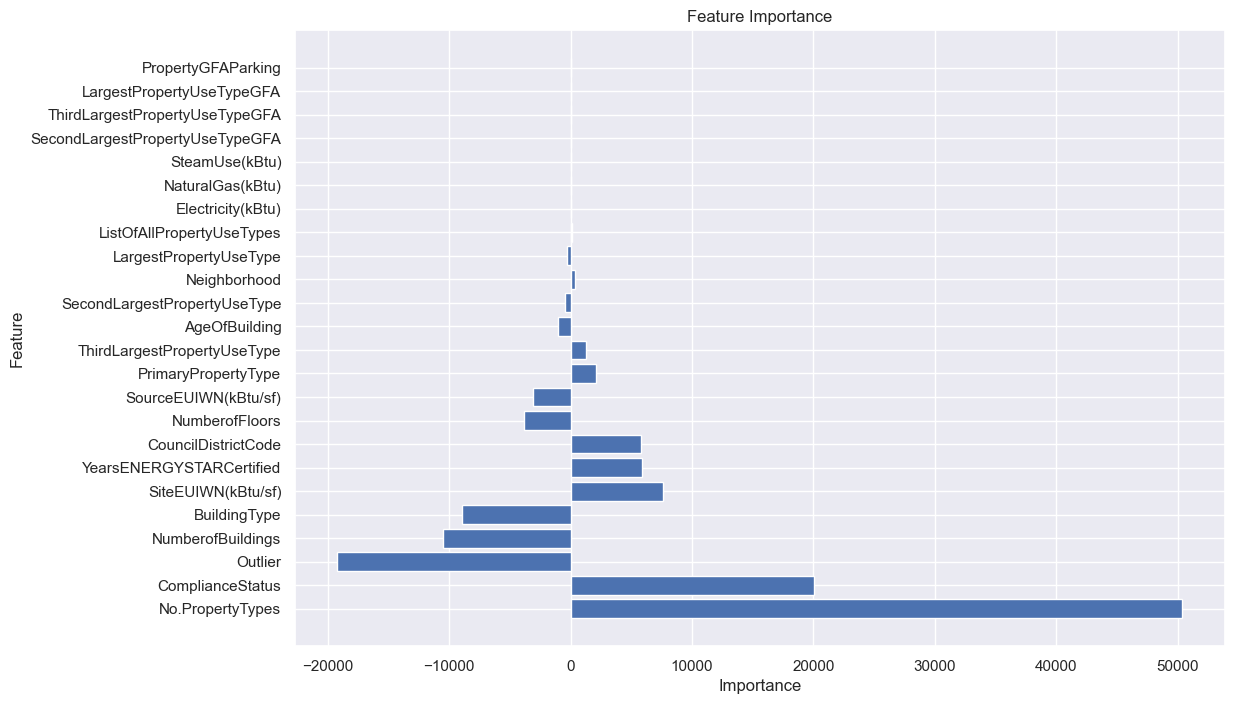

Feature Importance for best_linear_model_v1:
                            Feature    Importance
22                 No.PropertyTypes  50379.841042
20                 ComplianceStatus  20076.963000
21                          Outlier -19249.715201
4                 NumberofBuildings -10549.066290
0                      BuildingType  -8920.694817
15               SiteEUIWN(kBtu/sf)   7573.611797
14         YearsENERGYSTARCertified   5850.101711
2               CouncilDistrictCode   5798.400563
5                    NumberofFloors  -3809.962217
16             SourceEUIWN(kBtu/sf)  -3064.400467
1               PrimaryPropertyType   2061.435527
12      ThirdLargestPropertyUseType   1240.671707
23                    AgeOfBuilding  -1038.868925
10     SecondLargestPropertyUseType   -439.139959
3                      Neighborhood    335.697084
8            LargestPropertyUseType   -262.177356
7         ListOfAllPropertyUseTypes    113.829131
18                Electricity(kBtu)      1.014680
19   

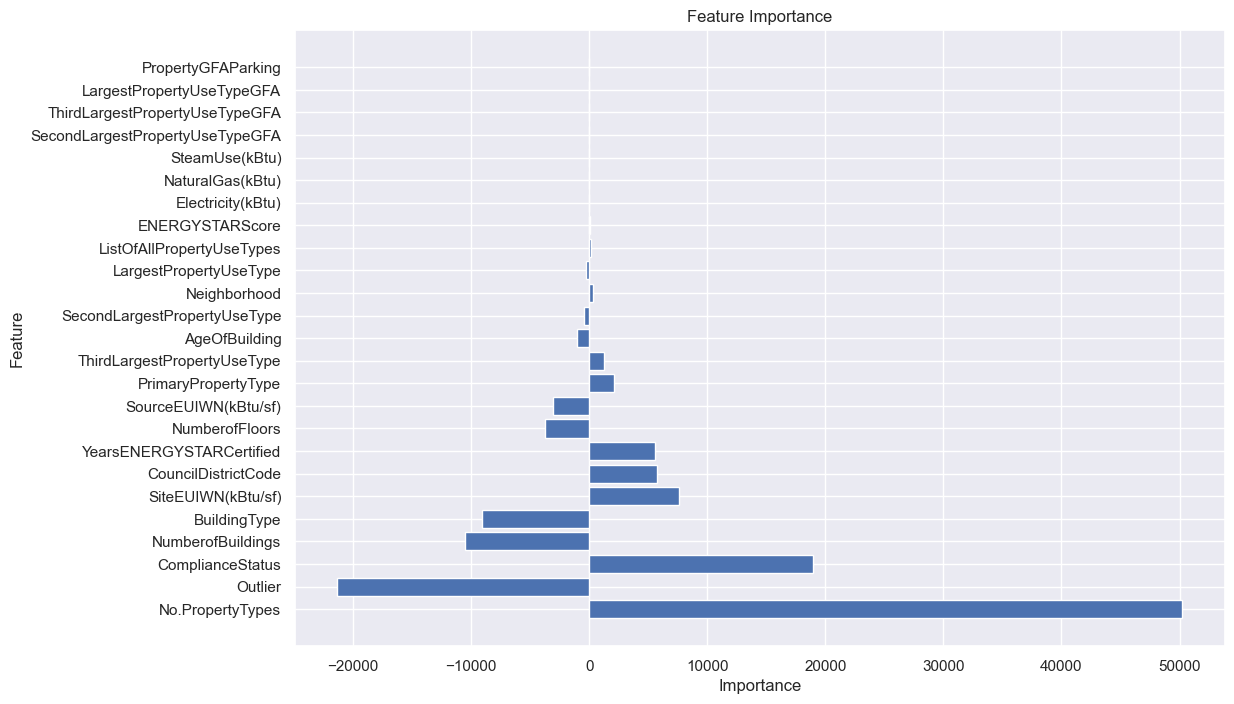

Feature Importance for best_linear_model_v2:
                            Feature    Importance
23                 No.PropertyTypes  50238.264782
22                          Outlier -21375.739363
21                 ComplianceStatus  18983.875075
4                 NumberofBuildings -10560.496204
0                      BuildingType  -9047.967678
16               SiteEUIWN(kBtu/sf)   7590.543471
2               CouncilDistrictCode   5724.191134
14         YearsENERGYSTARCertified   5562.055938
5                    NumberofFloors  -3774.857070
17             SourceEUIWN(kBtu/sf)  -3064.667227
1               PrimaryPropertyType   2095.907884
12      ThirdLargestPropertyUseType   1262.090268
24                    AgeOfBuilding  -1042.010601
10     SecondLargestPropertyUseType   -458.803856
3                      Neighborhood    293.715628
8            LargestPropertyUseType   -270.867863
7         ListOfAllPropertyUseTypes    112.682929
15                  ENERGYSTARScore     78.181225
19   

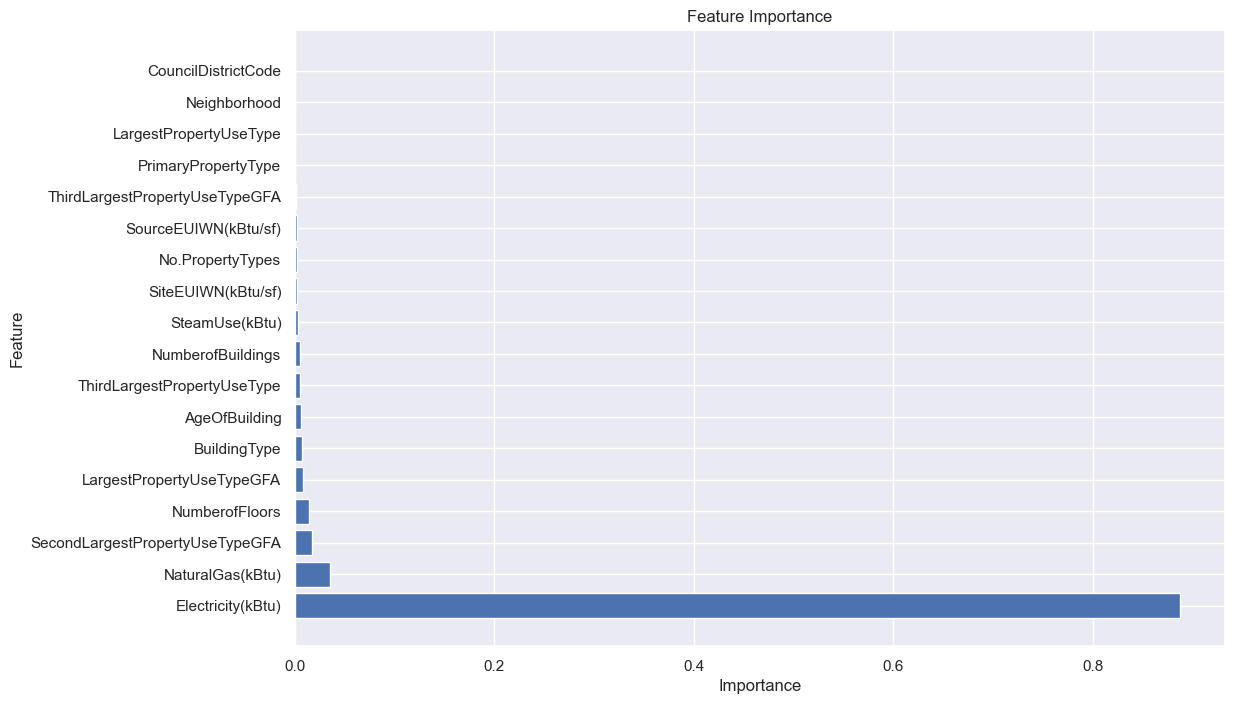

Feature Importance for best_nonlinear_model_v1:
                            Feature  Importance
14                Electricity(kBtu)    0.887923
15                 NaturalGas(kBtu)    0.035610
8   SecondLargestPropertyUseTypeGFA    0.016959
5                    NumberofFloors    0.014125
7         LargestPropertyUseTypeGFA    0.008389
0                      BuildingType    0.006913
17                    AgeOfBuilding    0.006073
9       ThirdLargestPropertyUseType    0.005521
4                 NumberofBuildings    0.005374
13                   SteamUse(kBtu)    0.002893
11               SiteEUIWN(kBtu/sf)    0.002380
16                 No.PropertyTypes    0.002372
12             SourceEUIWN(kBtu/sf)    0.002360
10   ThirdLargestPropertyUseTypeGFA    0.001444
1               PrimaryPropertyType    0.000777
6            LargestPropertyUseType    0.000754
3                      Neighborhood    0.000089
2               CouncilDistrictCode    0.000045


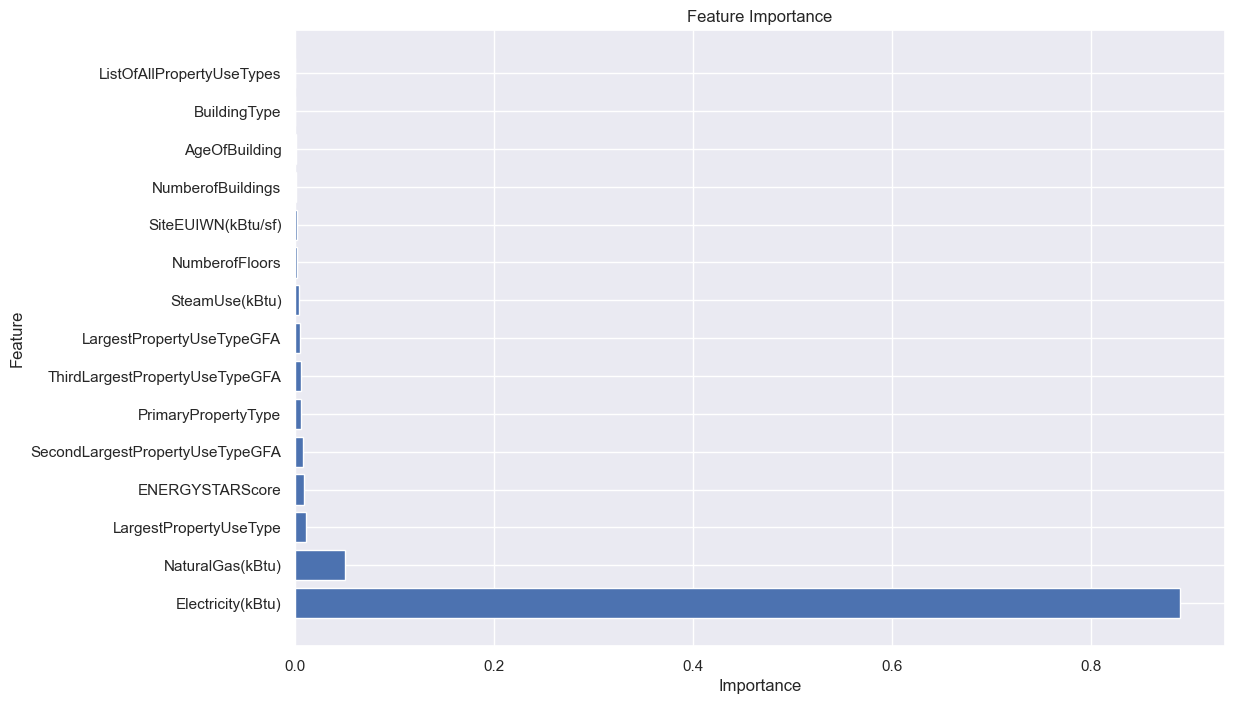

Feature Importance for best_nonlinear_model_v2:
                            Feature  Importance
12                Electricity(kBtu)    0.890151
13                 NaturalGas(kBtu)    0.050811
5            LargestPropertyUseType    0.011021
9                   ENERGYSTARScore    0.009049
7   SecondLargestPropertyUseTypeGFA    0.008011
1               PrimaryPropertyType    0.006904
8    ThirdLargestPropertyUseTypeGFA    0.006073
6         LargestPropertyUseTypeGFA    0.005501
11                   SteamUse(kBtu)    0.004562
3                    NumberofFloors    0.002490
10               SiteEUIWN(kBtu/sf)    0.002280
2                 NumberofBuildings    0.001546
14                    AgeOfBuilding    0.000965
0                      BuildingType    0.000487
4         ListOfAllPropertyUseTypes    0.000149


In [14]:
# For best_linear_model_v1
feature_importance_df_linear_v1 = get_feature_importance(best_model=best_grid_linear_model_v1, 
                                                         best_features=best_cols_linear_v1,
                                                         plot=True)
print("Feature Importance for best_linear_model_v1:")
print(feature_importance_df_linear_v1)

# For best_linear_model_v2
feature_importance_df_linear_v2 = get_feature_importance(best_model=best_grid_linear_model_v2, 
                                                         best_features=best_cols_linear_v2,
                                                         plot=True)
print("Feature Importance for best_linear_model_v2:")
print(feature_importance_df_linear_v2)

# For best_nonlinear_model_v1
feature_importance_df_nonlinear_v1 = get_feature_importance(best_model=best_grid_nonlinear_model_v1, 
                                                            best_features=best_cols_nonlinear_v1,
                                                            plot=True)
print("Feature Importance for best_nonlinear_model_v1:")
print(feature_importance_df_nonlinear_v1)

# For best_nonlinear_model_v2
feature_importance_df_nonlinear_v2 = get_feature_importance(best_model=best_grid_nonlinear_model_v2, 
                                                            best_features=best_cols_nonlinear_v2,
                                                            plot=True)
print("Feature Importance for best_nonlinear_model_v2:")
print(feature_importance_df_nonlinear_v2)
